# Simulating a 3D Lennard-Jones Fluid with Periodic Boundary Conditions

## Model

Distribute particles along a 3D lattice and initialize velocities according to a Boltzmann Distribution at starting temp Ti. Shift velocities so net velocitiy (center of mass velocity) is 0

Use velocity Verlet algorithm for MD steps

Calculate force by summing over all pairs of particles

Assume periodic boundary conditions and cutoff distance($ r_{c} $) < 1/2 diameter of box($ d_{box} $) so interactions are only between nearest periodic image. Therefore: $$ d_{x}(i,j) = x(i) - x(j) - d_{box} \cdot round\left(\frac{x(i) - x(j)}{d_{box}}\right) $$

Lennard-Jones Potential Energy: $$ V(r) = 4 \epsilon \left(\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^{6}\right) = 4 \left(\frac{1}{r^{*12}} - \frac{1}{r^{*6}}\right) = \frac{4}{r^{*6}} \left(\frac{1}{r^{*6}} - 1\right) $$

and Lennard-Jones Force: $$ F_{x}(r) = -\frac{\partial}{\partial x} \cdot V(r) = -\left(\frac{d_{x}}{r}\right)\left(\frac{\partial}{\partial r} \cdot V(r)\right) = \frac{48 d_{x}}{r^{*2}}\left(\frac{1}{r^{*12}} - 0.5\frac{1}{r^{*6}}\right) = \frac{48 d_{x}}{r^{*2}} \cdot \frac{1}{r^{*6}}\left(\frac{1}{r^{*6}} - 0.5\right) $$

where x = any cartesian axis, $ d_{x} $ = distance between particles i and j along axis x, and r = vector distance between particles i and j. Therefore in 3D space:

$$ r = \sqrt{d_{x}^{2} + d_{y}^{2} + d_{z}^{2}} $$

$$ V(d_{x}, d_{y}, d_{z}) = \frac{4}{\left(d_{x}^{2} + d_{y}^{2} + d_{z}^{2}\right)^{3}} \left(\frac{1}{\left(d_{x}^{2} + d_{y}^{2} + d_{z}^{2}\right)^{3}} - 1\right) $$

$$ F_{x}(d_{x}, d_{y}, d_{z}) = \frac{48 d_{x}}{d_{x}^{2} + d_{y}^{2} + d_{z}^{2}} \cdot \frac{1}{\left(d_{x}^{2} + d_{y}^{2} + d_{z}^{2}\right)^{3}}\left(\frac{1}{\left(d_{x}^{2} + d_{y}^{2} + d_{z}^{2}\right)^{3}} - 0.5\right) $$

Position: $$ x(t + dt) = x(t) + v(t)dt + \frac{F(t)}{2m}dt^{2} $$

Velocity: $$ v(t + dt) = v(t) + \frac{f(t + dt) + f(t)}{2m}dt = v(t) + \frac{f(t + dt)}{2m}dt + \frac{f(t)}{2m}dt = v(t + \frac{1}{2}dt) + \frac{f(t + dt)}{2m}dt $$

where $$ v(t + \frac{1}{2}dt) = v(t) + \frac{f(t)}{2m}dt $$

## Initialization

Imports:

In [14]:
%matplotlib inline
#%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()

Global Constants:

In [15]:
m = 1
dt = 0.01
cycles = 10000
ndim = 5
nparts = ndim**3
rho = 0.8442
Ti = 1.5043
dbox = ndim / np.cbrt(rho)
samfreq = 5
nbins = 50

## Definitions

In [16]:
#returns position after time delt using the velocity verlet method
def verPos(currPos, vel, frc):
    return currPos + (vel * dt) + (frc * dt**2 / 2 / m)

#returns velocity after time delt using the velocity verlet method with half timestep
def verVel(currVel, frc):
    return currVel + (dt * frc / 2 / m)

#returns distance between particle i and j along x axis 
def dist(xi, xj):
    return xi - xj - dbox * round((xi - xj) / dbox)

#returns 3D vector distance from distance components dx, dy, and dz
def vdist(dx, dy, dz):
    return np.sqrt(dx**2 + dy**2 + dz**2)

#returns LJ force along x axis
def force(dx, r):
    return 48 * dx * r**-2 * r**-6 * (r**-6 - 0.5)

#reutrns LJ potential
def potE(r):
    return 4 * r**-6 * (r**-6 - 1)

#returns kinetic energy
def kinE(v):
    return 0.5 * m * v**2

#Calculates forces across all pairs of particles
def forces(pos):
    #create new empty array
    frc = np.zeros([nparts, 3])
    #loop over all pairs of particles
    for i in range(nparts - 1):
        for j in range(i + 1, nparts):
            #calculate component and vector distance between particles i and j 
            dx = dist(pos[i,0], pos[j,0])
            dy = dist(pos[i,1], pos[j,1])
            dz = dist(pos[i,2], pos[j,2])
            r = vdist(dx, dy, dz)
            #calculate and save forces
            frc[i,0] += force(dx, r)
            frc[i,1] += force(dy, r)
            frc[i,2] += force(dz, r)
            frc[j,0] -= force(dx, r)
            frc[j,1] -= force(dy, r)
            frc[j,2] -= force(dz, r)
    return frc

#Calculates new positions
def positions(pos, vel, frc):
    #loop over all particles componentwise
    for i in range(nparts):
        for j in range(3):
            #calculate new position jth component of particle i
            pos[i,j] = verPos(pos[i,j], vel[i,j], frc[i,j])
    return pos

#Calculates new velocities
def velocities(vel, frc):
    #loop over all particles componentwise
    for i in range(nparts):
        for j in range(3):
            #calculate new velocity (at half time-step) jth component of particle i
            vel[i,j] = verVel(vel[i,j], frc[i,j])
    return vel

#Samples position data for calculating RDF
def gsample(ghist, pos):
    #loop over all pairs of particles
    for i in range(nparts - 1):
        for j in range(i + 1, nparts):
            #calculate component and vector distance between particles i and j
            dx = dist(pos[i,0], pos[j,0])
            dy = dist(pos[i,1], pos[j,1])
            dz = dist(pos[i,2], pos[j,2])
            r = vdist(dx, dy, dz)
            #check if r < rc
            if r < dbox / 2:
                #add contribution to histogram
                ig = int(r * 2 * nbins / dbox)
                ghist[ig] += 2
    return ghist

#Calculates final RDF
def gfinal(ghist, ngr):
    #create empty 2d array
    gr = np.zeros([nbins, 2])
    #loop over all bins
    for i in range(nbins):
        #central distance of ith bin
        r = dbox * (i + 0.5) / 2 / nbins
        #volume of ith bin
        vb = (4 / 3) * np.pi * ((i + 1)**3 - i**3) * (dbox / 2 / nbins)**3
        #number of ideal gas molecules in ith bin
        nid = vb * rho
        #save normalized RDF
        gr[i, 0] = r
        gr[i, 1] = ghist[i] / ngr / nparts / nid
    return gr


## Simulation

In [17]:
#Creating the arrays

Pos = np.zeros([nparts, 3])
Vel = np.zeros([nparts, 3])
Frc = np.zeros([nparts, 3])
ghist = np.zeros(nbins)
ngr = 0

#Filling the arrays with the initial conditions

#create nparts (ndim**3) by 3 array of points evenly distributed over a cubic lattice  of length dbox centered at the origin
Pos = np.vstack(np.meshgrid(np.linspace(-dbox/2,dbox/2,ndim),np.linspace(-dbox/2,dbox/2,ndim),np.linspace(-dbox/2,dbox/2,ndim))).reshape(3,-1).T
#Loop over 3 dimensional components
for i in range(3):
    sumV = 0
    #loop over all particles initalizing velocities to a Boltzmann distribution
    for j in range(nparts):
        Vel[j,i] = rng.normal(0, np.sqrt(Ti))
        sumV += Vel[j,i]
    #center of mass (net) velocity
    sumV = sumV / nparts
    #loop over all particles to set net velocity to 0
    for j in range(nparts):
        Vel[j,i] = Vel[j,i] - sumV

#MD Loop

for i in range(cycles):
    #velocity Verlet MD loop
    Frc = forces(Pos)
    Pos = positions(Pos, Vel, Frc)
    Vel = velocities(Vel, Frc)
    Frc = forces(Pos)
    Vel = velocities(Vel, Frc)
    #check if sampleing step
    if i % samfreq == 0:
        ghist = gsample(ghist, Pos)
        ngr += 1

#Finalization

gr = gfinal(ghist, ngr)
print(gr)

[[2.64519825e-02 0.00000000e+00]
 [7.93559474e-02 0.00000000e+00]
 [1.32259912e-01 0.00000000e+00]
 [1.85163877e-01 0.00000000e+00]
 [2.38067842e-01 0.00000000e+00]
 [2.90971807e-01 0.00000000e+00]
 [3.43875772e-01 0.00000000e+00]
 [3.96779737e-01 0.00000000e+00]
 [4.49683702e-01 0.00000000e+00]
 [5.02587667e-01 0.00000000e+00]
 [5.55491632e-01 0.00000000e+00]
 [6.08395597e-01 0.00000000e+00]
 [6.61299562e-01 0.00000000e+00]
 [7.14203526e-01 0.00000000e+00]
 [7.67107491e-01 0.00000000e+00]
 [8.20011456e-01 0.00000000e+00]
 [8.72915421e-01 0.00000000e+00]
 [9.25819386e-01 0.00000000e+00]
 [9.78723351e-01 0.00000000e+00]
 [1.03162732e+00 0.00000000e+00]
 [1.08453128e+00 0.00000000e+00]
 [1.13743525e+00 0.00000000e+00]
 [1.19033921e+00 0.00000000e+00]
 [1.24324318e+00 0.00000000e+00]
 [1.29614714e+00 2.37539415e-04]
 [1.34905111e+00 2.03613910e-04]
 [1.40195507e+00 0.00000000e+00]
 [1.45485904e+00 0.00000000e+00]
 [1.50776300e+00 0.00000000e+00]
 [1.56066697e+00 0.00000000e+00]
 [1.613570

Text(0.5, 1.0, 'Radial Distribution Function')

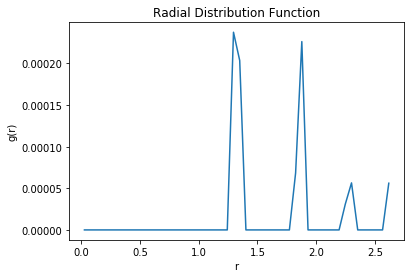

In [23]:
fig, aa = plt.subplots()
aa.plot(gr[0:,0], gr[0:,1], label='RDF')
plt.setp(aa, xlabel='r', ylabel='g(r)')
aa.set_title('Radial Distribution Function')